In [26]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports


In [29]:
# Standard Library Imports
import datetime
import json
import os
import sys
import time
from itertools import product

import igraph as ig
import matplotlib.pyplot as plt
import networkx as nx

# Third-Party Library Imports
import numpy as np
import pandas as pd
import scipy.sparse as sparse
import seaborn as sns
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Access environment variables
PYTHONPATH = os.getenv("PYTHONPATH")
DATA_DIR = os.getenv("DATA_DIR")
SRC_DIR = os.getenv("SRC_DIR")
OUTPUT_DIR = os.getenv("OUTPUT_DIR")

from src.visualization.edgebundling.addZCoordinate import ZCoordinateAdder
from src.visualization.edgebundling.frLayoutUtility import frLayoutUtility
from src.visualization.edgebundling.graphReadingUtility import graphReadingUtility
from src.visualization.edgebundling.graphToDfUtility import GraphProcessingUtility
from src.visualization.edgebundling.hammerBundling3D import hammer_bundle
from src.visualization.edgebundling.nodesEdgesJsonSaver import edgesSaver, nodesSaver
from src.visualization.edgebundling.postBundlingUtility import postBundlingUtility
from src.visualization.edgebundling.pruneEdges import pruneEdges

# Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None

# Set Seaborn Style
sns.set_style("white")

# Define Paths


In [32]:
subgraph = False

# 2. Constants and configuration
INPUT_GRAPH_PATH = DATA_DIR + "/08-analysis-data/2025/graph_analysis.graphml"
CLUSTER_TREE_PATH = (
    OUTPUT_DIR
    + "/cluster-qualifications_2025/cluster-label-tree/cluster_tree_filtered.json"
)
OUTPUT_DIR = DATA_DIR + "/09-threeJs/"
FR_GRAPH_FILENAME = (
    f"FR_Layout_Graph_{datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}.graphml"
)
# external env
THREEJS_OUTPUT_DIR = os.getenv("THREEJS_OUTPUT_DIR")
NODES_DATA_FILENAME = (
    f"nodes_{datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}scale2.json"
)
EDGES_DATA_FILENAME = (
    f"edges_{datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}scale2.json"
)

if subgraph:
    FR_GRAPH_FILENAME = f"SUBG_FR_Layout_Graph_{datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}.graphml"
    NODES_DATA_FILENAME = (
        f"SUBG_nodes_{datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}.json"
    )
    EDGES_DATA_FILENAME = (
        f"SUBG_edges_{datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}.json"
    )

## read and layout the graph


In [ ]:
g = graphReadingUtility.read_and_clean_graph(INPUT_GRAPH_PATH)
total_nodes = len(g.vs)
print(f"Total nodes in the graph: {total_nodes}")


if subgraph:

    cluster_list = list(range(30, 40))

    # subset to only cluster 0 to 100
    g = graphReadingUtility.subgraph_of_clusters(g, cluster_list)

    total_nodes = len(g.vs)
    print(f"Total nodes in the sub graph: {total_nodes}")
print("#" * 100)

################################################################################################
layout_params = {
    # "k": 0.5, # distance between nodes; best to leave it to algo
    "iterations": 50,  # (default=50) use 100
    "threshold": 0.0001,  # default 0.0001
    "weight": "weight",
    "scale": 10000,
    "center": (0, 0),
    "dim": 2,
    "seed": 1887,
}

g_fr, pos = frLayoutUtility.fr_layout_nx(g, layout_params)


print("#" * 100)


################################################################################################

# Add z-coordinate to nodes based on centrality
z_adder = ZCoordinateAdder(g_fr, percentage=20)
g_z = z_adder.add_z_coordinate_to_nodes()

print("#" * 100)

Node Attributes: ['title', 'year', 'cluster', 'doi', 'authors', 'node_index', 'node_name', 'centrality']
Edge Attributes: ['weight', 'edge_id']
Number of nodes: 36510
Number of edges: 551227
Total nodes in the graph: 36510
####################################################################################################
Starting Fruchterman-Reingold layout process...
Layout parameters: {'iterations': 50, 'threshold': 0.0001, 'weight': 'weight', 'scale': 10000, 'center': (0, 0), 'dim': 2, 'seed': 1887}
Converting to NetworkX Graph...
Conversion complete.
Graph has 36510 nodes and 551227 edges.
Calculating layout...
Layout calculation completed in 2090.16 seconds.
Processing layout results...
Layout boundaries:
X-axis: Min = -9105.25, Max = 10000.00
Y-axis: Min = -8821.60, Max = 9775.64
Assigning coordinates to nodes...
Layout process completed in 2091.86 seconds.
####################################################################################################
Z Coordinates are adde

## save graph with x, y, z coordinates


In [37]:
# Assuming g_z is your NetworkX graph object
full_path = OUTPUT_DIR + FR_GRAPH_FILENAME

# Save as GraphML file
nx.write_graphml(g_z, full_path)
print(f"Graph saved as GraphML: {full_path}")

# read back in
# full_path = OUTPUT_DIR +'FR_Layout_Graph_2025-04-16-21-30-09.graphml'
# g_z = nx.read_graphml(full_path)

Graph saved as GraphML: /Users/jlq293/Projects/Study-1-Bibliometrics/data/09-threeJs/FR_Layout_Graph_2025-05-13-13-44-03.graphml


In [ ]:
list(g_z.nodes(data=True))[0]

(0,
 {'title': 'Kinetics of citalopram in man; plasma levels in patients',
  'year': 1982,
  'cluster': 19,
  'doi': '10.1016/S0278-5846(82)80181-4',
  'authors': 'Overø',
  'node_index': 0,
  'node_name': '0',
  'centrality': 0.151957843626865,
  '_igraph_index': 0,
  'x': np.float64(-589.8026123046875),
  'y': np.float64(1040.77685546875),
  'z': np.float64(580.4662581995266)})

## Prune


In [ ]:
################################################################################################
# Prune edges by weight percentile
percentile_to_keep = 0.15  # we keep 15 %
pruner = pruneEdges(
    g_z,
)
print("Pruning edges by weight percentile:")
g_pruned_weight = pruner.prune_edges_by_weight_percentile(percentile_to_keep)
summary = pruner.get_prune_summary()
print("Summary after pruning by weight:")
print(summary)

print("\n" + "#" * 80 + "\n")

# Prune random percentage of edges
percentile_to_keep = 0.15  # we keep 15 %
pruner = pruneEdges(
    g_z,
)
print("Pruning edges randomly:")
g_pruned_random = pruner.prune_edges_randomly(percentile_to_keep)
summary = pruner.get_prune_summary()
print("Summary after random pruning:")
print(summary)

print("#" * 80)

Pruning edges by weight percentile:
Weight Threshold: 0.66
Edges with this weight: 0
Kept top 15.0% of edges by weight
Edges kept: 82684 out of 551227
Summary after pruning by weight:
{'initial_edge_count': 551227, 'final_edge_count': 82684, 'initial_isolates': 0, 'final_isolates': 6595}

################################################################################

Pruning edges randomly:
Kept 15.0% of edges randomly
Edges kept: 82684 out of 551227
Summary after random pruning:
{'initial_edge_count': 551227, 'final_edge_count': 82684, 'initial_isolates': 0, 'final_isolates': 2024}
################################################################################


## Dataframe conversion


In [40]:
# Convert nodes and edges to DataFrames
nodes_df = GraphProcessingUtility.nodes_to_dataframe(
    g_pruned_random,
    normalize_coordinates=False,
    drop_columns=["_nx_name"],
)
edges_df = GraphProcessingUtility.edges_to_dataframe(g_pruned_random)

# Add coordinates to edges
edges_with_coords = GraphProcessingUtility.create_edge_df_with_source_target_coords(
    edges_df, nodes_df
)

# Add segment lengths
edges_with_coords_with_length = GraphProcessingUtility.add_segment_length_to_edge_df(
    edges_with_coords
)

# Display the result
edges_with_coords_with_length.head(3)

Segment length statistics:
Min: 0.00
Max: 9938.82
Mean: 2005.04
Median: 1777.39


,edge_id,weight,source,target,source_x,source_y,source_z,target_x,target_y,target_z,segment_length
0,5,0.3,0,68,-589.802612,1040.776855,580.466258,155.815750,2225.178223,322.764857,1423.082342
1,17,0.3,0,383,-589.802612,1040.776855,580.466258,-1834.943115,895.700134,114.028767,1337.529835
2,19,0.3,0,445,-589.802612,1040.776855,580.466258,-551.641663,1365.706665,694.854177,346.583663


## Check Segment Length Distribution


Number of edges selected: 62013


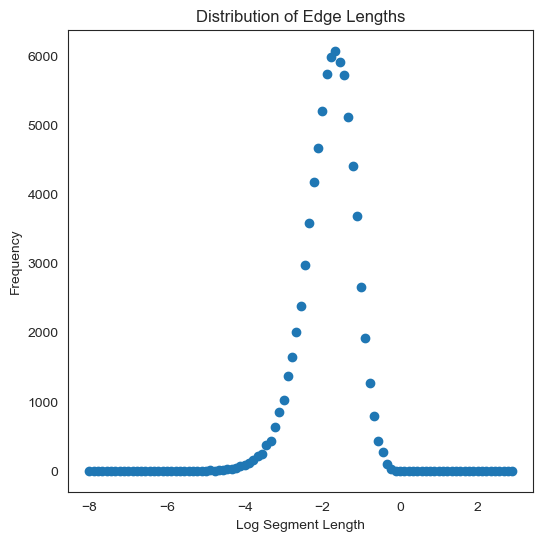

Number of edges selected: 20671


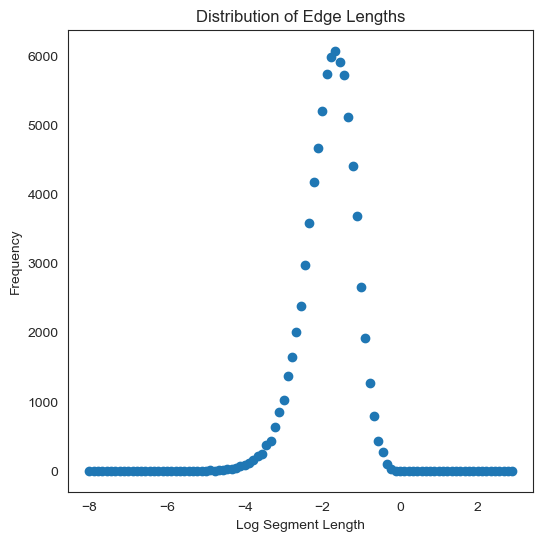

In [ ]:
class SegmentLengthDistribution:
    def __init__(self, nodes_df, edges_with_coords_with_length):
        """
        Initializes the GraphProcessor with the node and edge dataframes.

        Args:
            nodes_df (pd.DataFrame): DataFrame containing node information.
            edges_with_coords_with_length (pd.DataFrame): DataFrame containing edge data including coordinates and lengths.
        """
        self.nodes_df = nodes_df
        self.edges_df = edges_with_coords_with_length.copy()
        self.normalized_edge_df = self.edges_df.copy()

    def normalize_edges(self):
        """
        Normalize the coordinates and segment lengths in the edge dataframe.
        """
        to_normalize = [
            "source_x",
            "source_y",
            "source_z",
            "target_x",
            "target_y",
            "target_z",
            "segment_length",
        ]

        # Reset the node indices in edges_df to match those in nodes_df
        index_mapping = {
            old_index: new_index
            for new_index, old_index in enumerate(self.nodes_df["node_index"].unique())
        }

        # Map the source and target indices in the edges DataFrame
        self.normalized_edge_df["source"] = self.normalized_edge_df["source"].map(
            index_mapping
        )
        self.normalized_edge_df["target"] = self.normalized_edge_df["target"].map(
            index_mapping
        )

        # Normalize the relevant columns
        for col in to_normalize:
            self.normalized_edge_df[col] = GraphProcessingUtility.minmax_normalize(
                self.normalized_edge_df[col]
            )

    def create_adjacency_matrix(self, percentile=50):
        """
        Create an adjacency matrix for the graph using the normalized edges.

        Args:
            percentile (float): The percentile threshold to use for selecting edges based on segment length.
                                Default is the 50th percentile (median).

        Returns:
            mat (sparse.coo_matrix): Sparse matrix representing the adjacency matrix.
        """
        Nnodes = self.nodes_df.shape[0]

        # Calculate the length threshold based on the specified percentile
        length_threshold = np.percentile(
            self.normalized_edge_df["segment_length"], percentile
        )

        # Select edges whose length is above the specified percentile threshold
        subedges = self.normalized_edge_df["segment_length"] > length_threshold

        print(f"Number of edges selected: {subedges.sum()}")

        # Construct the adjacency matrix
        mat = sparse.coo_matrix(
            (
                np.ones(self.normalized_edge_df.loc[subedges].shape[0], dtype=int),
                (
                    self.normalized_edge_df.loc[subedges, "source"].values,
                    self.normalized_edge_df.loc[subedges, "target"].values,
                ),
            ),
            shape=(Nnodes, Nnodes),
        )

        return mat

    def find_connected_components(self, mat):
        """
        Find connected components in the graph represented by the adjacency matrix.

        Args:
            mat (sparse.coo_matrix): The adjacency matrix of the graph.

        Returns:
            tuple: A tuple containing the number of components and membership information for nodes.
        """
        ncomp, membership = sparse.csgraph.connected_components(mat)
        return ncomp, membership

    def plot_edge_length_distribution(self):
        """
        Visualize the distribution of edge lengths using a histogram. This helps us understand the distribution of
        segment lengths in the graph.
        """
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))

        # Histogram of segment lengths (log-binned)
        dist, bins = np.histogram(
            self.normalized_edge_df["segment_length"].values,
            bins=np.exp(np.linspace(-8, 3, 100)),
        )

        # Scatter plot of the log-transformed bins against the distribution
        ax.scatter(np.log(bins[:-1]), dist)

        # Add labels
        ax.set_xlabel("Log Segment Length")
        ax.set_ylabel("Frequency")
        ax.set_title("Distribution of Edge Lengths")

        plt.show()


# Example usage
graph_processor = SegmentLengthDistribution(nodes_df, edges_with_coords_with_length)
graph_processor.normalize_edges()
adjacency_matrix = graph_processor.create_adjacency_matrix(
    percentile=25
)  # Using 75th percentile instead of median
n_components, membership = graph_processor.find_connected_components(adjacency_matrix)
graph_processor.plot_edge_length_distribution()

adjacency_matrix = graph_processor.create_adjacency_matrix(
    percentile=75
)  # Using 75th percentile instead of median
n_components, membership = graph_processor.find_connected_components(adjacency_matrix)
graph_processor.plot_edge_length_distribution()

# BUNDLE


In [ ]:
# get dictionary of segment length, 25th, 50th, 75th percentile
segment_length_dict = {
    "10th_percentile": edges_with_coords_with_length["segment_length"].quantile(0.10),
    "20th_percentile": edges_with_coords_with_length["segment_length"].quantile(0.20),
    "25th_percentile": edges_with_coords_with_length["segment_length"].quantile(0.25),
    "50th_percentile": edges_with_coords_with_length["segment_length"].median(),
    "75th_percentile": edges_with_coords_with_length["segment_length"].quantile(0.75),
}
segment_length_dict

{'10th_percentile': np.float64(721.8847849544482),
 '20th_percentile': np.float64(1016.9112325540167),
 '25th_percentile': np.float64(1142.5117451278677),
 '50th_percentile': 1777.393841948577,
 '75th_percentile': np.float64(2623.2297406991997)}

## Set Threshold for Edge Length


In [ ]:
# get edges to bundle above a certain threshold
# threshold = 0.03
threshold = segment_length_dict["20th_percentile"]
edges_to_bundle = edges_with_coords_with_length["segment_length"] > threshold
edges_to_bundle_df = edges_with_coords_with_length.loc[edges_to_bundle].reset_index(
    drop=True
)
print(f"Total Nr of Pruned Edges: {len(edges_with_coords_with_length)}")
print(f"Edges to Bundle: {edges_to_bundle.sum()}")
print(
    f"Edges without bundling: {len(edges_with_coords_with_length)- edges_to_bundle.sum()}"
)

Total Nr of Pruned Edges: 82684
Edges to Bundle: 66147
Edges without bundling: 16537


## Bundling


In [ ]:
bundled_edge_pts = hammer_bundle(
    nodes_df[["x", "y", "z"]],
    edges_to_bundle_df[["source", "target"]],
    initial_bandwidth=0.05,
    decay=0.7,
    tension=0.3,
    accuracy=5 * 10**2,
    weight=None,
    advect_iterations=50,
    iterations=5,
    min_segment_length=0.01,
    max_segment_length=0.05,
)
bundled_edge_pts.head()

Process Bundling
Start Bundling
Start Smoothing


,x,y,z
0,-589.802612,1040.776855,580.466258
1,-611.444868,1218.169654,576.356399
2,-611.648901,1407.123757,566.410742
3,-577.450308,1605.814831,547.460891
4,-502.141951,1802.459956,518.310153


## Post Bundling Processing

add source and target columns, create clean df and save it


In [ ]:
# Example of how to use the class
edge_processor = postBundlingUtility(
    bundled_edge_pts, edges_to_bundle_df, edges_with_coords_with_length, threshold
)
final_edges_df = edge_processor.post_process_edges()

Number of bundled edges: 66147
Number of total edges: 82684
Number of straight edges: 16537


# SAVER


In [ ]:
e_saver = edgesSaver(final_edges_df, nodes_df)
edges_df_with_color = e_saver.add_color_attr()
edges_df_with_color_year = e_saver.add_year_attr()
edges_df_with_color_year_id = e_saver.add_id_attr()


edges_list = e_saver.transform_edges(
    extra_edge_attributes=["source", "target", "color", "year", "id"]
)

print("Example of an edge:")
print(edges_list[0])

# Save to JSON
e_saver.save_edges_to_json(edges_list, OUTPUT_DIR + "smaller_" + EDGES_DATA_FILENAME)
e_saver.save_edges_to_json(
    edges_list,
    THREEJS_OUTPUT_DIR + "smaller_" + EDGES_DATA_FILENAME,
)

Color attribute added to edges. 
-1 if inter-clusters, cluster number if intra-cluster edge.
Year attribute added to edges. Using the more recent year if different.
ID attribute added to edges.
Example of an edge:
{'source': 0, 'target': 68, 'color': -1, 'year': 1982, 'id': '0_68', 'points': [{'x': -589.8026123047, 'y': 1040.7768554687, 'z': 580.4662581995}, {'x': -611.4448679352, 'y': 1218.1696540929, 'z': 576.3563991844}, {'x': -611.6489008889, 'y': 1407.1237566398, 'z': 566.4107417126}, {'x': -577.4503078251, 'y': 1605.8148307307, 'z': 547.4608911963}, {'x': -502.1419509286, 'y': 1802.4599558967, 'z': 518.310152527}, {'x': -385.8898022273, 'y': 1984.3602964434, 'z': 479.5159228394}, {'x': -236.9203002943, 'y': 2147.4287140607, 'z': 433.2997666028}, {'x': -71.277953556, 'y': 2299.0783193298, 'z': 383.374107317}, {'x': 155.8157501221, 'y': 2225.1782226562, 'z': 322.7648573393}]}
Edges data saved to /Users/jlq293/Projects/Study-1-Bibliometrics/data/09-threeJs/smaller_edges_2025-05-13-1

In [47]:
# save final edges df to csv for easy access and safety

edges_df_with_color_year_id.to_csv(
    OUTPUT_DIR + "smaller_" + "final_bundled_edges_df_2025-05-13.csv", index=False
)

# save nodes


In [ ]:
# save nodes
OUTPUT_DIRA = OUTPUT_DIR + NODES_DATA_FILENAME

OUTPUT_DIRB = THREEJS_OUTPUT_DIR + NODES_DATA_FILENAME

n_saver = nodesSaver()
nodes_json = n_saver.save_dataframe_nodes_to_json(
    nodes_df,
    paths=[OUTPUT_DIRA, OUTPUT_DIRB],
    return_json=True,
    attributes=[
        "node_index",
        "year",
        "title",
        "cluster",
        "doi",
        "authors",
        "centrality",
        "x",
        "y",
        "z",
    ],
)

print("Example of a node:")
nodes_json[0]

Graph nodes saved to /Users/jlq293/Projects/Study-1-Bibliometrics/data/09-threeJs/nodes_2025-05-13-13-44-03scale2.json
Graph nodes saved to /Users/jlq293/Projects/Random Projects/LW-ThreeJS/2d_ssrinetworkviz/src/data/nodes_2025-05-13-13-44-03scale2.json
Example of a node:


{'node_index': 0,
 'year': 1982,
 'title': 'Kinetics of citalopram in man; plasma levels in patients',
 'cluster': 19,
 'doi': '10.1016/S0278-5846(82)80181-4',
 'authors': 'Overø',
 'centrality': 0.151957843626865,
 'x': -589.8026123046875,
 'y': 1040.77685546875,
 'z': 580.4662581995266}